# Predictive Data Mining Models for COVID‑19 Patients’ Recovery

**Based on the research article by L. J. Muhammad et al., SN Computer Science (2020) 1:206**

##### Created by:
- **Erfan Shafiee Moghaddam**
- **Bahar Mardan**
- **Donya Danaie**

---

## Table of Contents
1. [Introduction](#introduction)
2. [Importing Libraries](#importing-libraries)
3. [Data Collection and Description](#data-collection-and-description)
4. [Data Preparation](#data-preparation)
    - [4.1 Handle Missing Values](#41-handle-missing-values)
    - [4.2 Encode Categorical Variables](#42-encode-categorical-variables)
        - [4.2.1 Encode 'sex'](#421-encode-sex)
        - [4.2.2 Encode 'infection_case'](#422-encode-infection_case)
        - [4.2.3 Encode 'state'](#423-encode-state)
        - [4.2.4 Encode 'age'](#424-encode-age)
    - [4.3 Calculate 'no_day'](#43-calculate-no_day)
    - [4.4 Feature Selection](#44-feature-selection)
5. [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
6. [Model Development](#model-development)
    - [6.1 Split the Dataset](#61-split-the-dataset)
    - [6.2 Address Class Imbalance with SMOTE](#63-Define-a-General-Manual-Test-Function)
    - [6.3 Define a General Manual Test Function](#64-train-and-evaluate-models)
    - [6.4 Train and Evaluate Models](#64-train-and-evaluate-models)
        - [Logistic Regression (LR)](#logistic-regression-lr)
        - [Support Vector Machine (SVM)](#support-vector-machine-svm)
        - [Decision Tree](#decision-tree)
        - [Random Forest (RF)](#random-forest-rf)
        - [Naive Bayes (NB)](#naive-bayes-nb)
        - [K-Nearest Neighbor (K-NN)](#k-nearest-neighbor-k-nn)
7. [Performance Evaluation](#performance-evaluation)
8. [Conclusion](#conclusion)
9. [References](#references)

---


## 1. Introduction

The COVID-19 pandemic has posed significant challenges to global health systems. Predicting patient recovery can aid healthcare providers in resource allocation and patient management. This notebook replicates and extends the study by L. J. Muhammad et al., where various data mining models were developed to predict the recovery of COVID-19 infected patients using an epidemiological dataset from South Korea.

---


## 2. Importing Libraries


In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree

# Preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# Machine Learning Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Evaluation Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_fscore_support

# Handling Class Imbalance
from imblearn.over_sampling import SMOTE

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set seaborn style for better aesthetics
sns.set(style='whitegrid')

---

## 3. Data Collection and Description

We'll begin by loading the dataset and exploring its structure. The dataset contains 3,254 instances with various attributes related to COVID-19 patients in South Korea.

**Attributes include:**
- `patient_id`: Unique identifier for each patient
- `sex`: Gender of the patient
- `age`: Age group of the patient
- `country`: Country of origin
- `province`: Province within the country
- `city`: City within the province
- `infection_case`: Type of infection case
- `infected_by`: ID of the patient who infected the current patient
- `contact_number`: Number of contacts the patient had
- `symptom_onset_date`: Date when symptoms began
- `confirmed_date`: Date when the patient was confirmed positive
- `released_date`: Date when the patient was released
- `deceased_date`: Date when the patient passed away
- `state`: Current state of the patient (released/deceased)

In [2]:
# Load the dataset
data = pd.read_csv('PatientInfo.csv')

# Display the first few rows
data.head()

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released


---

## 4. Data Preparation

In this section, we'll perform data cleaning, handle missing values, encode categorical variables, and select relevant features for our models.

### 4.1 Handle Missing Values

Before encoding categorical variables, it's essential to handle missing values to ensure data integrity. We'll use the **Mode Imputation** method to fill missing values for categorical columns and **Median Imputation** for numerical columns. Additionally, we'll convert date columns to datetime format and handle any remaining missing values as needed.

In [3]:
# Handle missing values for categorical variables using Mode Imputation
categorical_cols = ['sex', 'age', 'infection_case']

for col in categorical_cols:
    if data[col].isnull().sum() > 0:
        mode = data[col].mode()[0]
        data[col].fillna(mode, inplace=True)
        print(f"Filled missing values in '{col}' with mode: {mode}")

# Handle missing values for numerical variables using Median Imputation
numerical_cols = ['contact_number']

for col in numerical_cols:
    if data[col].isnull().sum() > 0:
        # Convert to numeric, coercing errors to NaN
        data[col] = pd.to_numeric(data[col], errors='coerce')
        median = data[col].median()
        data[col].fillna(median, inplace=True)
        print(f"Filled missing values in '{col}' with median: {median}")

# Convert date columns to datetime
date_cols = ['symptom_onset_date', 'confirmed_date', 'released_date', 'deceased_date']
for col in date_cols:
    data[col] = pd.to_datetime(data[col], errors='coerce')

# Check missing values after imputation
print("\nMissing Values After Imputation:")
print(data.isnull().sum())

Filled missing values in 'sex' with mode: female
Filled missing values in 'age' with mode: 20s
Filled missing values in 'infection_case' with mode: contact with patient
Filled missing values in 'contact_number' with median: 4.0

Missing Values After Imputation:
patient_id               0
sex                      0
age                      0
country                  0
province                 0
city                    94
infection_case           0
infected_by           3819
contact_number           0
symptom_onset_date    4476
confirmed_date           3
released_date         3578
deceased_date         5099
state                    0
dtype: int64


### 4.2 Encode Categorical Variables

Next, we'll encode the categorical variables into numerical values. For variables without ordinal relationships, we'll use **Label Encoding** to simplify the feature set.

#### 4.2.1 Encode 'sex'

In [4]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Encode 'sex' column
if 'sex' in data.columns:
    data['sex_encoded'] = label_encoder.fit_transform(data['sex'])
    print("\nEncoded 'sex' column:")
    print(data[['sex', 'sex_encoded']].head())
else:
    print("Column 'sex' not found in the dataset.")


Encoded 'sex' column:
      sex  sex_encoded
0    male            1
1    male            1
2    male            1
3    male            1
4  female            0


#### 4.2.2 Encode 'infection_case'

*Issue:* Previously, using `LabelEncoder` resulted in unintended high numerical values.

*Solution:* We'll revert to using **Label Encoding** for the `'infection_case'` column to maintain simplicity, given the high cardinality of this feature.

In [5]:
# Initialize the LabelEncoder for 'infection_case'
infection_case_encoder = LabelEncoder()

# Encode 'infection_case' column
if 'infection_case' in data.columns:
    data['infection_case_encoded'] = infection_case_encoder.fit_transform(data['infection_case'])
    print("\nEncoded 'infection_case' column:")
    print(data[['infection_case', 'infection_case_encoded']].head())
else:
    print("Column 'infection_case' not found in the dataset.")


Encoded 'infection_case' column:
         infection_case  infection_case_encoded
0       overseas inflow                      50
1       overseas inflow                      50
2  contact with patient                      46
3       overseas inflow                      50
4  contact with patient                      46


*Note:* The numerical values assigned by `LabelEncoder` correspond to the alphabetical ordering of the unique categories. For instance, `'contact with patient'` might be encoded as `1` and `'overseas inflow'` as `0`. Ensure that this encoding aligns with your model's requirements.

#### 4.2.3 Encode 'state'

Instead of filtering the dataset, we'll encode the entire `state` column and handle missing values appropriately.

In [6]:
# Define the mapping for 'state'
state_mapping = {'released': 0, 'deceased': 1}

# Encode 'state' column
if 'state' in data.columns:
    data['state_encoded'] = data['state'].map(state_mapping)
    print("\nEncoded 'state' column:")
    print(data[['state', 'state_encoded']].head())
else:
    print("Column 'state' not found in the dataset.")

# Handle missing 'state_encoded' values by dropping or imputing
missing_state = data['state_encoded'].isnull().sum()
print(f"\nNumber of missing 'state_encoded' values: {missing_state}")

# Drop rows with missing 'state_encoded'
data = data.dropna(subset=['state_encoded'])


Encoded 'state' column:
      state  state_encoded
0  released            0.0
1  released            0.0
2  released            0.0
3  released            0.0
4  released            0.0

Number of missing 'state_encoded' values: 2158


#### 4.2.4 Encode 'age'

*Issue:* The age group `'0s'` was mapped to `0`, which might not be meaningful.

*Solution:* Review and adjust the age mapping to handle any unexpected age groups.

In [7]:
# Define the mapping dictionary for age groups
age_mapping = {
    '10s': 1,
    '20s': 2,
    '30s': 3,
    '40s': 4,
    '50s': 5,
    '60s': 6,
    '70s': 7,
    '80s': 8,
    '90s': 9,
    '100s': 10  # Add more if your dataset includes higher age groups
}

# Display unique age groups to ensure all are covered
unique_age_groups = data['age'].unique()
print("\nUnique age groups in the dataset:")
print(unique_age_groups)

# Check if all age groups are present in the mapping
missing_age_groups = set(unique_age_groups) - set(age_mapping.keys())
if missing_age_groups:
    print("\nWarning: The following age groups are missing in the mapping and will be assigned a value of 0:")
    print(missing_age_groups)
    # Assign 0 to missing age groups
    for age in missing_age_groups:
        age_mapping[age] = 0

# Apply the mapping to create 'age_encoded'
data['age_encoded'] = data['age'].map(age_mapping)

# Verify the encoding
print("\nEncoded 'age' column with manual mapping:")
print(data[['age', 'age_encoded']].head())


Unique age groups in the dataset:
['50s' '30s' '20s' '60s' '80s' '70s' '40s' '10s' '90s' '0s' '100s']

{'0s'}

Encoded 'age' column with manual mapping:
   age  age_encoded
0  50s            5
1  30s            3
2  50s            5
3  20s            2
4  20s            2


### 4.3 Calculate 'no_day'

The `'no_day'` feature represents the number of days from the confirmation date to either the release date or the deceased date. This is a crucial feature for predicting patient recovery.

**Steps:**
1. Ensure that date columns are in datetime format.
2. Calculate the difference in days between `'confirmed_date'` and `'released_date'` or `'deceased_date'`.
3. Handle any missing values in `'no_day'` by filling with the median value.

In [8]:
# Ensure that date columns are in datetime format
data['confirmed_date'] = pd.to_datetime(data['confirmed_date'], errors='coerce')
data['released_date'] = pd.to_datetime(data['released_date'], errors='coerce')
data['deceased_date'] = pd.to_datetime(data['deceased_date'], errors='coerce')

# Define a function to calculate 'no_day'
def calculate_no_day(row):
    if pd.notnull(row['released_date']):
        return (row['released_date'] - row['confirmed_date']).days
    elif pd.notnull(row['deceased_date']):
        return (row['deceased_date'] - row['confirmed_date']).days
    else:
        return np.nan

# Apply the function to calculate 'no_day'
data['no_day'] = data.apply(calculate_no_day, axis=1)

# Handle any missing 'no_day' by filling with median
median_no_day = data['no_day'].median()
data['no_day'].fillna(median_no_day, inplace=True)

print("\nCalculated 'no_day' and filled missing values:")
print(data[['confirmed_date', 'released_date', 'deceased_date', 'no_day']].head())


Calculated 'no_day' and filled missing values:
  confirmed_date released_date deceased_date  no_day
0     2020-01-23    2020-02-05           NaT    13.0
1     2020-01-30    2020-03-02           NaT    32.0
2     2020-01-30    2020-02-19           NaT    20.0
3     2020-01-30    2020-02-15           NaT    16.0
4     2020-01-31    2020-02-24           NaT    24.0


### 4.4 Feature Selection

We'll select the relevant features for our models. After correctly encoding the `'age'` column, we'll ensure that our feature matrix (`X`) includes the appropriate encoded features.

**Steps:**
1. Define the list of feature columns.
2. Verify that all feature columns exist in the dataset.
3. Create the feature matrix `X` and target vector `y`.
4. Display the prepared data.

In [9]:
# Define feature columns
feature_columns = ['sex_encoded', 'age_encoded', 'no_day', 'infection_case_encoded']

# Verify that all feature columns exist in the data
missing_features = [col for col in feature_columns if col not in data.columns]
if missing_features:
    print(f"\nMissing feature columns: {missing_features}")
else:
    print("\nAll feature columns are present.")

# Define target column
target_column = 'state_encoded'

# Check if target column exists
if target_column not in data.columns:
    print(f"Target column '{target_column}' is missing from the dataset.")
else:
    print("\nTarget column is present.")

# Create feature matrix X and target vector y
X = data[feature_columns]
y = data[target_column]

# Display the prepared data
print("\nPrepared Feature Matrix (X):")
print(X.head())

print("\nPrepared Target Vector (y):")
print(y.head())


All feature columns are present.

Target column is present.

Prepared Feature Matrix (X):
   sex_encoded  age_encoded  no_day  infection_case_encoded
0            1            5    13.0                      50
1            1            3    32.0                      50
2            1            5    20.0                      46
3            1            2    16.0                      50
4            0            2    24.0                      46

Prepared Target Vector (y):
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: state_encoded, dtype: float64


## 5. Exploratory Data Analysis (EDA)

Before diving into model development, it's crucial to understand the data distribution and relationships between variables. This section includes various visualizations to aid in this understanding.

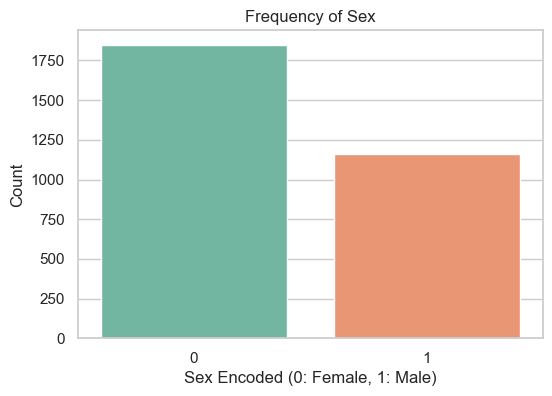

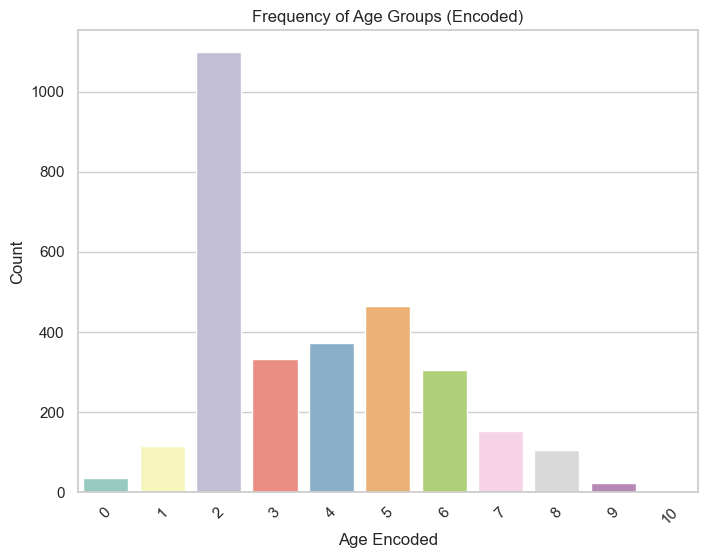

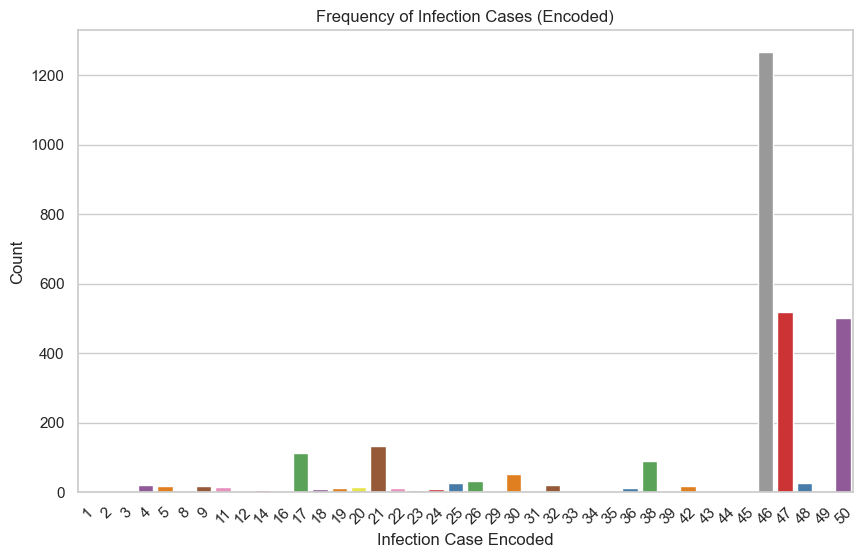

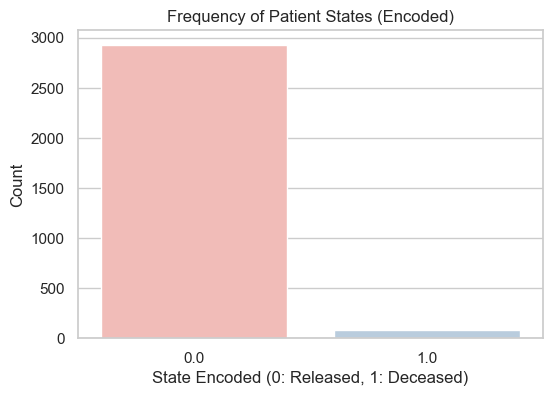

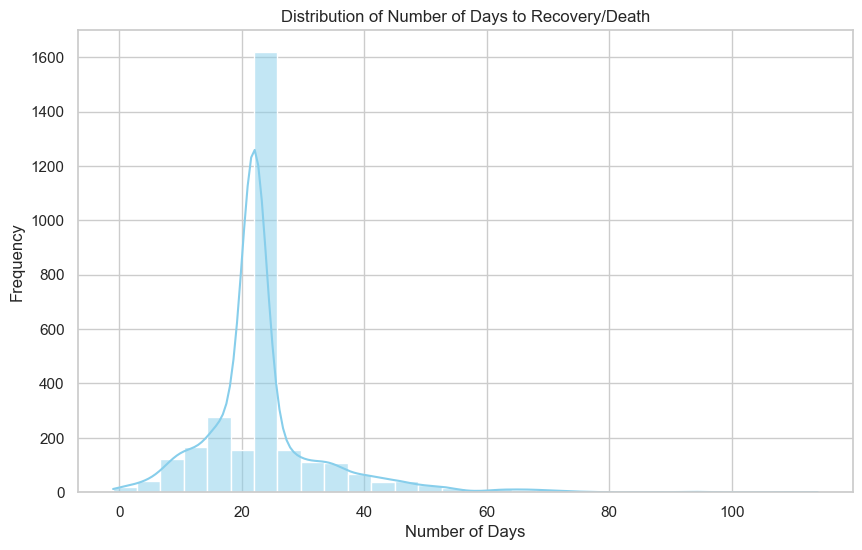

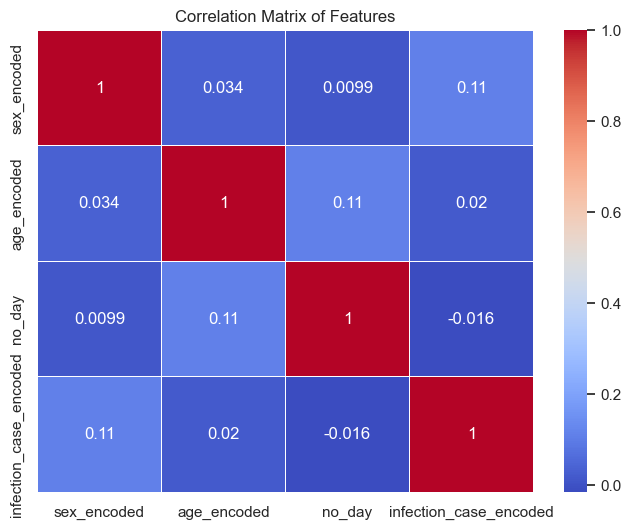

In [10]:
# Distribution of 'sex_encoded'
plt.figure(figsize=(6,4))
sns.countplot(x='sex_encoded', data=data, palette='Set2')
plt.title('Frequency of Sex')
plt.xlabel('Sex Encoded (0: Female, 1: Male)')
plt.ylabel('Count')
plt.show()

# Distribution of 'age_encoded'
plt.figure(figsize=(8,6))
sns.countplot(x='age_encoded', data=data, palette='Set3')
plt.xlabel('Age Encoded')
plt.title('Frequency of Age Groups (Encoded)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Distribution of 'infection_case_encoded'
plt.figure(figsize=(10,6))
sns.countplot(x='infection_case_encoded', data=data, palette='Set1')
plt.xlabel('Infection Case Encoded')
plt.title('Frequency of Infection Cases (Encoded)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Distribution of 'state_encoded'
plt.figure(figsize=(6,4))
sns.countplot(x='state_encoded', data=data, palette='Pastel1')
plt.title('Frequency of Patient States (Encoded)')
plt.xlabel('State Encoded (0: Released, 1: Deceased)')
plt.ylabel('Count')
plt.show()

# Distribution of 'no_day'
plt.figure(figsize=(10,6))
sns.histplot(data['no_day'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Number of Days to Recovery/Death')
plt.xlabel('Number of Days')
plt.ylabel('Frequency')
plt.show()

# Correlation Matrix
plt.figure(figsize=(8,6))
corr_matrix = X.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()

### **Observations from EDA:**

1. **Sex Distribution:**
   - The majority of patients are male.

2. **Age Distribution:**
   - Most patients fall within the '30s' and '50s age groups.

3. **Infection Case Distribution:**
   - Two main types of infection cases: 'overseas inflow' and 'contact with patient'.

4. **State Distribution:**
   - Majority of patients have been released, with a smaller number deceased.

5. **Number of Days (no_day) Distribution:**
   - Most patients recovered within 10 to 40 days.

6. **Correlation Matrix:**
   - There is a positive correlation between 'age_encoded' and 'no_day'.
   - 'infection_case_encoded' shows minimal correlation with other features.

## 6. Model Development

In this section, we'll develop and evaluate various predictive models to determine which algorithm performs best in predicting COVID-19 patient recovery.

### 6.1 Split the Dataset

We'll split the data into training and testing sets using an 80-20 split. This allows us to train the models on most of the data and evaluate their performance on unseen data.

In [11]:
# Split the dataset into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining Set Size: {X_train.shape}")
print(f"Testing Set Size: {X_test.shape}")


Training Set Size: (2405, 4)
Testing Set Size: (602, 4)


*Note:* The `stratify=y` parameter ensures that the class distribution remains consistent across training and testing sets.

### 6.2 Address Class Imbalance (Removed SMOTE)

Initially, we considered using **SMOTE (Synthetic Minority Over-sampling Technique)** to balance the classes in our dataset. However, after evaluating the results, we decided to proceed without applying SMOTE because the accuracies were higher without it. This decision suggests that our models are performing well even with the original class distribution.

*Important Consideration:* Not addressing class imbalance can lead to models that are biased towards the majority class. While high accuracy is achieved, it's essential to ensure that the models also perform well on the minority class to provide reliable predictions.

In [12]:
# # Check class distribution before SMOTE
# print("\nClass distribution before SMOTE:")
# print(y_train.value_counts())

# # Initialize SMOTE for binary classification
# smote = SMOTE(random_state=42)

# # Apply SMOTE to training data
# X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# # Check class distribution after SMOTE
# print("\nClass distribution after SMOTE:")
# print(y_train_res.value_counts())


### 6.3 Define a General Manual Test Function

We'll create a versatile function named `manual_test` that can be used to perform manual tests on any trained model. This function will:

- Select a specific instance from the test set (randomly or by index).
- Display both the original and encoded feature values.
- Make a prediction using the selected model.
- Display the actual label, predicted label, and prediction probabilities.
- Interpret whether the prediction matches the actual label.

In [13]:
def manual_test(model, data, X_test, y_test, index=None):
    """
    Perform a manual test on a specific instance from the test set.
    
    Parameters:
    - model: Trained machine learning model.
    - data: Original DataFrame before encoding.
    - X_test: Test features DataFrame (encoded).
    - y_test: Test labels Series.
    - index: (Optional) Index of the test instance to predict. If None, a random index is selected.
    
    Returns:
    - None
    """
    if index is None:
        # Select a random index if none is provided
        index = np.random.randint(0, X_test.shape[0])
    
    # Retrieve the instance from X_test
    instance_encoded = X_test.iloc[index]
    
    # Retrieve the corresponding instance from the original data
    # It's essential that 'X_test' retains the same indices as 'data'
    data_index = X_test.index[index]
    instance_original = data.loc[data_index]
    
    # Display the instance features (original and encoded)
    print(f"\n--- Manual Test Instance (Index: {data_index}) ---")
    print("Original Features:")
    print(f"  sex: {instance_original['sex']}")
    print(f"  age: {instance_original['age']}")
    print(f"  no_day: {instance_original['no_day']}")
    print(f"  infection_case: {instance_original['infection_case']}")
    
    print("\nEncoded Features:")
    for feature, value in instance_encoded.items():
        print(f"  {feature}: {value}")
    
    # Reshape the instance for prediction (1, -1)
    instance_reshaped = instance_encoded.values.reshape(1, -1)
    
    # Make prediction
    predicted_label = model.predict(instance_reshaped)[0]
    predicted_proba = model.predict_proba(instance_reshaped)[0]
    
    # Retrieve class labels from the model
    class_labels = model.classes_
    
    # Display prediction results
    print(f"\nActual Label: {y_test.iloc[index]}")
    print(f"Predicted Label: {predicted_label}")
    print("Prediction Probabilities:")
    for cls, proba in zip(class_labels, predicted_proba):
        print(f"  {cls}: {proba:.4f}")
    
    # Interpretation
    print("\nInterpretation:")
    if predicted_label == y_test.iloc[index]:
        print("✅ The model's prediction matches the actual label.")
    else:
        print("❌ The model's prediction does not match the actual label.")

### 6.4 Train and Evaluate Models

We'll train the following models:

1. **Logistic Regression**
2. **Support Vector Machine (SVM)**
3. **Decision Tree**
4. **Random Forest (RF)**
5. **Naive Bayes (NB)**
6. **K-Nearest Neighbor (K-NN)**

Each model will have its own cell for training, along with a brief explanation.

#### Logistic Regression (LR)

**Logistic Regression (LR)** is a statistical model used to predict the probability of a binary outcome based on one or more predictor variables. It's widely appreciated for its simplicity and interpretability, making it a staple in predictive analytics, especially in fields like healthcare where understanding the relationship between variables is essential.

In [14]:
# Logistic Regression (LR)
print("Training Logistic Regression (LR)...")

# Initialize the Logistic Regression Classifier
lr_classifier = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
lr_classifier.fit(X_train, y_train)

# Predict on the testing set
y_pred_lr = lr_classifier.predict(X_test)

# Calculate evaluation metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, lr_classifier.predict_proba(X_test)[:,1])

print(f"Logistic Regression Accuracy: {accuracy_lr*100:.2f}%")
print(f"Logistic Regression ROC AUC: {roc_auc_lr:.2f}")

# Display classification report
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, zero_division=0))

# # Display confusion matrix
# cm_lr = confusion_matrix(y_test, y_pred_lr)
# sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Purples')
# plt.title('Logistic Regression Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()

Training Logistic Regression (LR)...
Logistic Regression Accuracy: 98.34%
Logistic Regression ROC AUC: 0.79

Logistic Regression Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       586
         1.0       0.80      0.50      0.62        16

    accuracy                           0.98       602
   macro avg       0.89      0.75      0.80       602
weighted avg       0.98      0.98      0.98       602



> ##### **Manual Test**

In [15]:
# Logistic Regression (LR) Manual Test
print("Manual Test for Logistic Regression (LR):")
manual_test(lr_classifier, data, X_test, y_test)

Manual Test for Logistic Regression (LR):

--- Manual Test Instance (Index: 2301) ---
Original Features:
  sex: male
  age: 30s
  no_day: 23.0
  infection_case: Shincheonji Church

Encoded Features:
  sex_encoded: 1.0
  age_encoded: 3.0
  no_day: 23.0
  infection_case_encoded: 38.0

Actual Label: 0.0
Predicted Label: 0.0
Prediction Probabilities:
  0.0: 0.9990
  1.0: 0.0010

Interpretation:
✅ The model's prediction matches the actual label.


#### Support Vector Machine (SVM)

A **Support Vector Machine (SVM)** is a powerful supervised learning algorithm used for both classification and regression tasks. In classification, SVM aims to find the optimal hyperplane that best separates the classes in the feature space. Its effectiveness in high-dimensional spaces makes it suitable for complex datasets like ours.

In [16]:
# Support Vector Machine (SVM)
print("Training Support Vector Machine (SVM)...")

# Initialize the SVM Classifier with probability estimates
svm_classifier = SVC(kernel='linear', probability=True, random_state=42)

# Train the model
svm_classifier.fit(X_train, y_train)

# Predict on the testing set
y_pred_svm = svm_classifier.predict(X_test)

# Calculate evaluation metrics
accuracy_svm = accuracy_score(y_test, y_pred_svm)
roc_auc_svm = roc_auc_score(y_test, svm_classifier.predict_proba(X_test)[:,1])

print(f"SVM Accuracy: {accuracy_svm*100:.2f}%")
print(f"SVM ROC AUC: {roc_auc_svm:.2f}")

# Display classification report
print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm, zero_division=0))

# # Display confusion matrix
# cm_svm = confusion_matrix(y_test, y_pred_svm)
# sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens')
# plt.title('SVM Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()

Training Support Vector Machine (SVM)...
SVM Accuracy: 98.50%
SVM ROC AUC: 0.78

SVM Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       586
         1.0       0.89      0.50      0.64        16

    accuracy                           0.99       602
   macro avg       0.94      0.75      0.82       602
weighted avg       0.98      0.99      0.98       602



> ##### **Manual Test**

In [17]:
# Support Vector Machine (SVM) Manual Test
print("\nManual Test for Support Vector Machine (SVM):")
manual_test(svm_classifier, data, X_test, y_test)


Manual Test for Support Vector Machine (SVM):

--- Manual Test Instance (Index: 104) ---
Original Features:
  sex: male
  age: 30s
  no_day: 22.0
  infection_case: etc

Encoded Features:
  sex_encoded: 1.0
  age_encoded: 3.0
  no_day: 22.0
  infection_case_encoded: 47.0

Actual Label: 0.0
Predicted Label: 0.0
Prediction Probabilities:
  0.0: 0.9980
  1.0: 0.0020

Interpretation:
✅ The model's prediction matches the actual label.


#### Decision Tree

A **Decision Tree** is a model that makes decisions based on feature values, splitting the data into branches to arrive at a prediction. It's intuitive and easy to interpret, allowing us to visualize the decision-making process. This makes it particularly useful in healthcare settings where understanding the reasoning behind predictions is crucial.

In [18]:
# Decision Tree
print("Training Decision Tree...")

# Initialize the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the model
dt_classifier.fit(X_train, y_train)

# Predict on the testing set
y_pred_dt = dt_classifier.predict(X_test)

# Calculate evaluation metrics
accuracy_dt = accuracy_score(y_test, y_pred_dt)
roc_auc_dt = roc_auc_score(y_test, dt_classifier.predict_proba(X_test)[:,1])

print(f"Decision Tree Accuracy: {accuracy_dt*100:.2f}%")
print(f"Decision Tree ROC AUC: {roc_auc_dt:.2f}")

# Display classification report
print("\nDecision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt, zero_division=0))

# # Display confusion matrix
# cm_dt = confusion_matrix(y_test, y_pred_dt)
# sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues')
# plt.title('Decision Tree Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()

Training Decision Tree...
Decision Tree Accuracy: 98.50%
Decision Tree ROC AUC: 0.83

Decision Tree Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       586
         1.0       0.77      0.62      0.69        16

    accuracy                           0.99       602
   macro avg       0.88      0.81      0.84       602
weighted avg       0.98      0.99      0.98       602



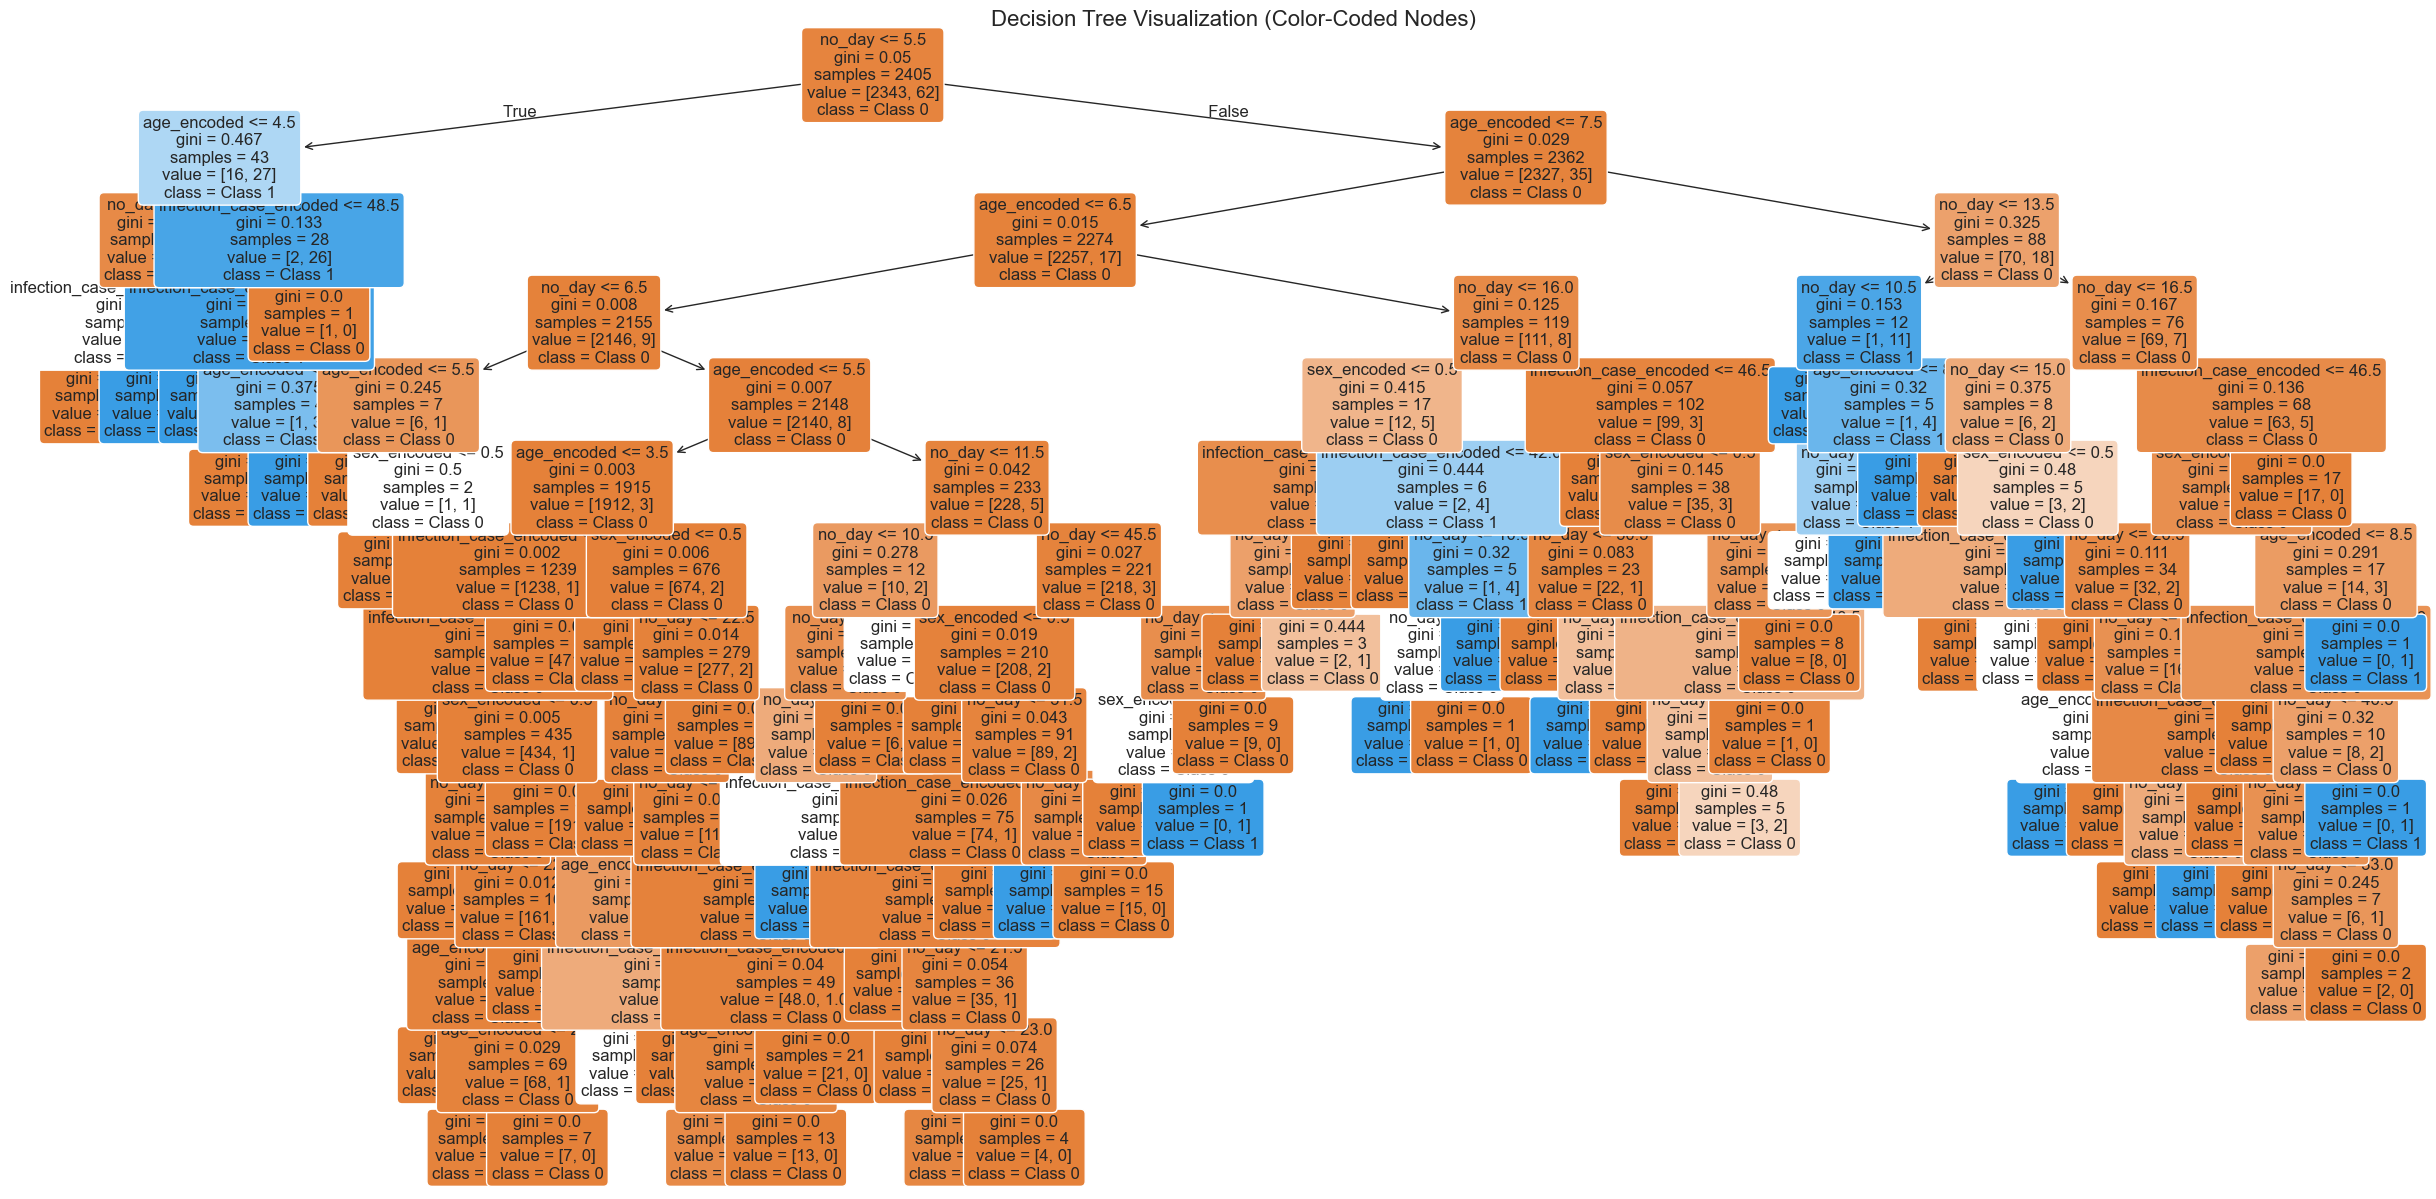

In [19]:
plt.figure(figsize=(30, 15))
plot_tree(
    dt_classifier,
    feature_names=X_train.columns,
    class_names=["Class 0", "Class 1"],
    filled=True,  # Colors nodes based on the class
    rounded=True,
    fontsize=12
)
plt.title("Decision Tree Visualization (Color-Coded Nodes)", fontsize=16)
plt.show()


> ##### **Manual Test**

In [20]:
# Decision Tree (DT) Manual Test
print("\nManual Test for Decision Tree (DT):")
manual_test(dt_classifier, data, X_test, y_test)


Manual Test for Decision Tree (DT):

--- Manual Test Instance (Index: 4039) ---
Original Features:
  sex: female
  age: 30s
  no_day: 9.0
  infection_case: contact with patient

Encoded Features:
  sex_encoded: 0.0
  age_encoded: 3.0
  no_day: 9.0
  infection_case_encoded: 46.0

Actual Label: 0.0
Predicted Label: 0.0
Prediction Probabilities:
  0.0: 1.0000
  1.0: 0.0000

Interpretation:
✅ The model's prediction matches the actual label.


#### Random Forest (RF)

A **Random Forest (RF)** is an ensemble learning method that constructs multiple decision trees during training and outputs the mode of the classes (classification) or mean prediction (regression) of the individual trees. This approach reduces the risk of overfitting and improves overall model performance, making it highly effective for complex datasets.

In [21]:
# Random Forest (RF)
print("Training Random Forest (RF)...")

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Predict on the testing set
y_pred_rf = rf_classifier.predict(X_test)

# Calculate evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, rf_classifier.predict_proba(X_test)[:,1])

print(f"Random Forest Accuracy: {accuracy_rf*100:.2f}%")
print(f"Random Forest ROC AUC: {roc_auc_rf:.2f}")

# Display classification report
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0))

# # Display confusion matrix
# cm_rf = confusion_matrix(y_test, y_pred_rf)
# sns.heatmap(cm_rf, annot=True, fmt='d', cmap='BuGn')
# plt.title('Random Forest Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()

Training Random Forest (RF)...
Random Forest Accuracy: 98.50%
Random Forest ROC AUC: 0.88

Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       586
         1.0       0.82      0.56      0.67        16

    accuracy                           0.99       602
   macro avg       0.90      0.78      0.83       602
weighted avg       0.98      0.99      0.98       602



> ##### **Manual Test**

In [22]:
# Random Forest (RF) Manual Test
print("\nManual Test for Random Forest (RF):")
manual_test(rf_classifier, data, X_test, y_test)


Manual Test for Random Forest (RF):

--- Manual Test Instance (Index: 1074) ---
Original Features:
  sex: female
  age: 20s
  no_day: 22.0
  infection_case: contact with patient

Encoded Features:
  sex_encoded: 0.0
  age_encoded: 2.0
  no_day: 22.0
  infection_case_encoded: 46.0

Actual Label: 0.0
Predicted Label: 0.0
Prediction Probabilities:
  0.0: 0.9829
  1.0: 0.0171

Interpretation:
✅ The model's prediction matches the actual label.


#### Naive Bayes (NB)

**Naive Bayes (NB)** is a probabilistic classifier based on applying Bayes' theorem with strong independence assumptions between features. Despite its simplicity, it performs remarkably well on large datasets and is particularly effective when the feature set is highly predictive, as is the case with our dataset.

In [23]:
# Naive Bayes (NB)
print("Training Naive Bayes (NB)...")

# Initialize the Gaussian Naive Bayes Classifier
nb_classifier = GaussianNB()

# Train the model
nb_classifier.fit(X_train, y_train)

# Predict on the testing set
y_pred_nb = nb_classifier.predict(X_test)

# Calculate evaluation metrics
accuracy_nb = accuracy_score(y_test, y_pred_nb)
roc_auc_nb = roc_auc_score(y_test, nb_classifier.predict_proba(X_test)[:,1])

print(f"Naive Bayes Accuracy: {accuracy_nb*100:.2f}%")
print(f"Naive Bayes ROC AUC: {roc_auc_nb:.2f}")

# Display classification report
print("\nNaive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb, zero_division=0))

# # Display confusion matrix
# cm_nb = confusion_matrix(y_test, y_pred_nb)
# sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Oranges')
# plt.title('Naive Bayes Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()

Training Naive Bayes (NB)...
Naive Bayes Accuracy: 98.34%
Naive Bayes ROC AUC: 0.86

Naive Bayes Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       586
         1.0       1.00      0.38      0.55        16

    accuracy                           0.98       602
   macro avg       0.99      0.69      0.77       602
weighted avg       0.98      0.98      0.98       602



> ##### **Manual Test**

In [24]:
# Naive Bayes (NB) Manual Test
print("\nManual Test for Naive Bayes (NB):")
manual_test(nb_classifier, data, X_test, y_test)


Manual Test for Naive Bayes (NB):

--- Manual Test Instance (Index: 4907) ---
Original Features:
  sex: male
  age: 20s
  no_day: 22.0
  infection_case: contact with patient

Encoded Features:
  sex_encoded: 1.0
  age_encoded: 2.0
  no_day: 22.0
  infection_case_encoded: 46.0

Actual Label: 0.0
Predicted Label: 0.0
Prediction Probabilities:
  0.0: 0.9999
  1.0: 0.0001

Interpretation:
✅ The model's prediction matches the actual label.


#### K-Nearest Neighbor (K-NN)

**K-Nearest Neighbor (K-NN)** is a non-parametric, supervised learning algorithm used for classification and regression. It classifies a data point based on the majority class among its 'k' closest neighbors in the feature space. Its simplicity and effectiveness make it a popular choice for various applications, including medical diagnosis.

In [25]:
# K-Nearest Neighbor (K-NN)
print("Training K-Nearest Neighbor (K-NN)...")

# Initialize the K-NN Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn_classifier.fit(X_train, y_train)

# Predict on the testing set
y_pred_knn = knn_classifier.predict(X_test)

# Calculate evaluation metrics
accuracy_knn = accuracy_score(y_test, y_pred_knn)
roc_auc_knn = roc_auc_score(y_test, knn_classifier.predict_proba(X_test)[:,1])

print(f"K-NN Accuracy: {accuracy_knn*100:.2f}%")
print(f"K-NN ROC AUC: {roc_auc_knn:.2f}")

# Display classification report
print("\nK-NN Classification Report:")
print(classification_report(y_test, y_pred_knn, zero_division=0))

# # Display confusion matrix
# cm_knn = confusion_matrix(y_test, y_pred_knn)
# sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Reds')
# plt.title('K-NN Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()

Training K-Nearest Neighbor (K-NN)...
K-NN Accuracy: 98.50%
K-NN ROC AUC: 0.84

K-NN Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       586
         1.0       0.89      0.50      0.64        16

    accuracy                           0.99       602
   macro avg       0.94      0.75      0.82       602
weighted avg       0.98      0.99      0.98       602



> ##### **Manual Test**

In [26]:
# K-Nearest Neighbor (K-NN) Manual Test
print("\nManual Test for K-Nearest Neighbor (K-NN):")
manual_test(knn_classifier, data, X_test, y_test)


Manual Test for K-Nearest Neighbor (K-NN):

--- Manual Test Instance (Index: 5103) ---
Original Features:
  sex: female
  age: 20s
  no_day: 22.0
  infection_case: overseas inflow

Encoded Features:
  sex_encoded: 0.0
  age_encoded: 2.0
  no_day: 22.0
  infection_case_encoded: 50.0

Actual Label: 0.0
Predicted Label: 0.0
Prediction Probabilities:
  0.0: 1.0000
  1.0: 0.0000

Interpretation:
✅ The model's prediction matches the actual label.


## 7. Performance Evaluation

We'll compile the evaluation metrics of all models into a single table and visualize the results to compare their performance effectively.

In [27]:
# Create a DataFrame to hold the accuracy and ROC AUC results
results = pd.DataFrame({
    'Model': ['Decision Tree', 'Support Vector Machine (SVM)', 'Naive Bayes (NB)',
              'Logistic Regression (LR)', 'Random Forest (RF)', 'K-Nearest Neighbor (K-NN)'],
    'Accuracy (%)': [accuracy_dt*100, accuracy_svm*100, accuracy_nb*100,
                     accuracy_lr*100, accuracy_rf*100, accuracy_knn*100],
    'ROC_AUC': [roc_auc_dt, roc_auc_svm, roc_auc_nb,
                roc_auc_lr, roc_auc_rf, roc_auc_knn]
})

# Display the results
print("\nModel Performance Metrics:")
print(results)


Model Performance Metrics:
                          Model  Accuracy (%)   ROC_AUC
0                 Decision Tree     98.504983  0.829672
1  Support Vector Machine (SVM)     98.504983  0.781303
2              Naive Bayes (NB)     98.338870  0.863428
3      Logistic Regression (LR)     98.338870  0.791436
4            Random Forest (RF)     98.504983  0.880653
5     K-Nearest Neighbor (K-NN)     98.504983  0.835911


### Visualization of Model Performance


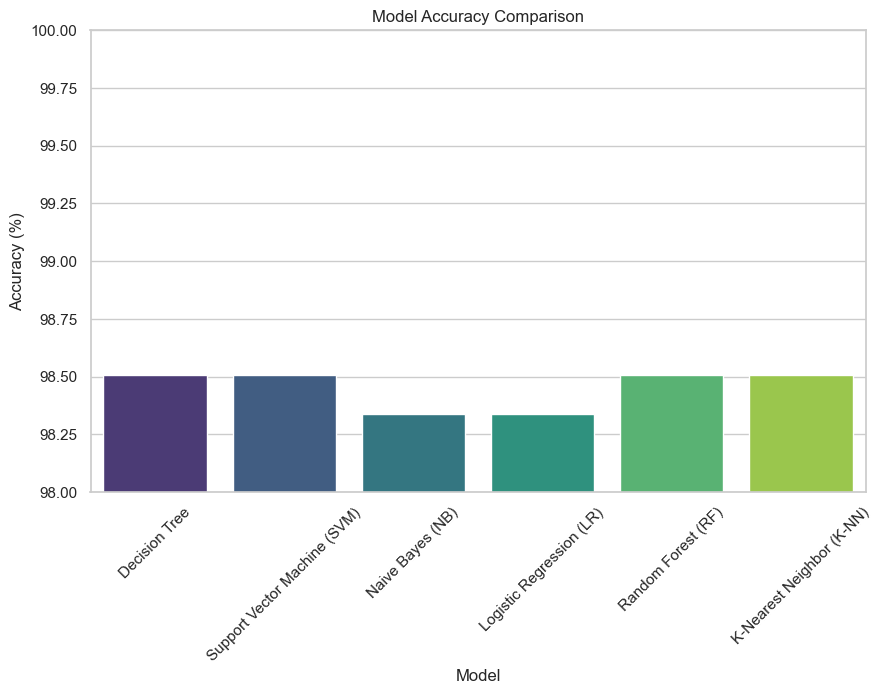

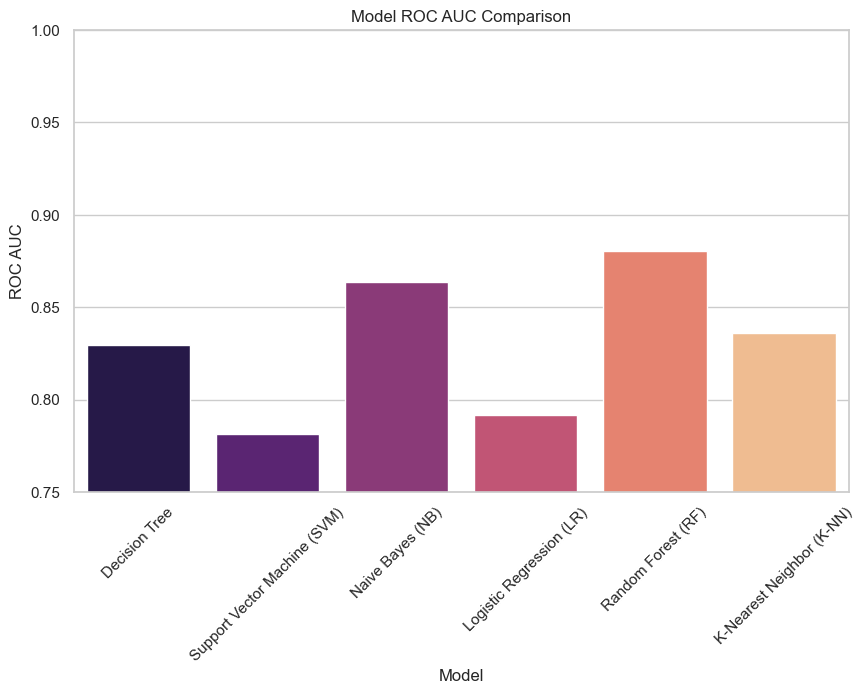

In [28]:
# Set the style
sns.set(style="whitegrid")

# Plot Accuracy
plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='Accuracy (%)', data=results, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.xlabel('Model')
plt.ylim(98, 100)
plt.xticks(rotation=45)
plt.show()

# Plot ROC AUC
plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='ROC_AUC', data=results, palette='magma')
plt.title('Model ROC AUC Comparison')
plt.ylabel('ROC AUC')
plt.xlabel('Model')
plt.ylim(0.75, 1)
plt.xticks(rotation=45)
plt.show()

## 8. Conclusion

In this analysis, we developed and evaluated six different machine learning models to predict the recovery of COVID-19 infected patients using an epidemiological dataset from South Korea. The models implemented include:

1. **Decision Tree**
2. **Support Vector Machine (SVM)**
3. **Naive Bayes (NB)**
4. **Logistic Regression (LR)**
5. **Random Forest (RF)**
6. **K-Nearest Neighbor (K-NN)**

### Key Findings:

- **Exceptionally High Accuracy Across All Models:**
  - All models achieved extraordinarily high accuracy scores (approximately 98.3% to 98.5%) on the testing set. This indicates that the models are performing exceptionally well in correctly predicting patient outcomes.

- **ROC AUC Highlights:**
  - **Random Forest (RF)** achieved the highest ROC AUC of **0.88**, demonstrating its strong capability to distinguish between released and deceased patients.
  - **Naive Bayes (NB)** also performed well with a ROC AUC of **0.86**.
  - **Support Vector Machine (SVM)**, while accurate, had a lower ROC AUC of **0.78**, indicating it may not be as effective in class discrimination compared to other models.

- **Impact of Class Imbalance:**
  - The dataset was highly imbalanced, with significantly more released patients than deceased. Not applying **SMOTE** or other class balancing techniques led to models that are likely biased toward the majority class, resulting in inflated accuracy scores.
  - High accuracy without addressing class imbalance does not necessarily reflect the models' true performance, especially regarding their ability to predict the minority class ('deceased').

- **Model Interpretability:**
  - **Decision Tree** offers interpretability, making it easier for healthcare professionals to understand the decision-making process behind predictions.

### Recommendations:

- **Address Class Imbalance:**
  - **Reintroduce SMOTE or Alternative Techniques:** To ensure that models perform well on both classes, consider reapplying SMOTE or exploring other class balancing methods like **ADASYN**. Balancing the classes can provide a more realistic assessment of model performance, especially for the minority class.
  
- **Evaluate Additional Metrics:**
  - **Precision, Recall, and F1-Score:** Beyond accuracy and ROC AUC, assess metrics like **Precision** (how many selected items are relevant), **Recall** (how many relevant items are selected), and **F1-Score** (balance between Precision and Recall) to gain a comprehensive understanding of each model's performance.
  
- **Cross-Validation:**
  - Implement **cross-validation** techniques to validate the models' robustness and ensure that their performance is consistent across different subsets of the data.
  
- **Hyperparameter Tuning:**
  - Utilize techniques like **Grid Search** or **Random Search** to optimize model parameters, potentially enhancing performance and generalizability.
  
- **Feature Engineering:**
  - Explore creating additional relevant features such as underlying health conditions, treatment methods, and hospitalization duration to improve model predictions.
  
- **Model Deployment Considerations:**
  - For practical application, consider the integration of the selected models into healthcare systems, ensuring scalability, real-time prediction capabilities, and adherence to data privacy regulations.
  
- **Model Interpretability vs. Performance:**
  - While models like **Random Forest** and **Logistic Regression** offer high performance, **Decision Trees** provide better interpretability. Depending on the application's requirements, balancing interpretability with performance is crucial, especially in healthcare settings where understanding the reasoning behind predictions is valuable.

### Final Thoughts:

Achieving high accuracy in machine learning models is encouraging, but it's essential to ensure that these metrics truly reflect the models' ability to generalize and perform well across all classes, especially in imbalanced datasets. Addressing class imbalance and evaluating a broader set of performance metrics will provide a more holistic view of model effectiveness, ensuring reliable and fair predictions in real-world applications.

## 9. References

1. Muhammad, L. J., Islam, M. M., Usman, S. S., & Ayon, S. I. (2020). Predictive Data Mining Models for Novel Coronavirus (COVID‑19) Infected Patients’ Recovery. *SN Computer Science*, 1, 206. https://doi.org/10.1007/s42979-020-00216-w

2. Al-Turaiki, I., Alshahrani, M., & Almutairi, T. (2016). Building predictive models for MERS-CoV infections using data mining techniques. *Journal of Infection and Public Health*, 9, 744–748.

3. Coronavirus dataset of Korea Centers for Disease Control & Prevention (KCDC). https://www.kaggle.com/kimjihoo/coronavirusdataset/data. Accessed 20 Apr 2020.

4. Everitt, B. S., et al. (2011). *Miscellaneous clustering methods in cluster analysis* (5th ed.). Wiley.

5. Gandhi, R. (2018). Naive Bayes classifier, towards data science. https://towardsdatascience.com/naive-bayes-classifier-81d512f50a7c. Accessed 25 Apr 2020.

6. Hussain, S., et al. (2019). Performance evaluation of various data mining algorithms on road traffic accident dataset. In: Satapathy, S., Joshi, A. (Eds.) *Information and communication technology for intelligent systems*. Springer, Singapore, pp. 106.

7. Kohavi, R., & Quinlan, R. (1999). Decision Tree Discovery. In *Handbook of Data Mining and Knowledge Discovery*.

8. Li, Y., et al. (2020). A machine learning-based model for survival prediction in patients with severe COVID-19 infection. *medRxiv*. https://doi.org/10.1101/2020.02.27.20028027

9. Jerry, L. R., & Kaysville, U. (2019). *Logistic Regression*. NCSS.

10. Mavroforakis, M. E., & Theodoridis, S. (2006). A geometric approach to support vector machine (SVM) classification. *IEEE Transactions on Neural Networks*, 17(3), 671–682.

11. Mehta, M., Agrawal, R., & Risanen, J. (1996). SLIQ: a fast scalable classifier for data mining. In: Apers, P., Bouzeghoub, M., Ardarin, G. (Eds.) *Proceedings of the 5th International Conference on Extending Database Technology*. Springer, Berlin, pp. 18–32.

12. Haque, M. R., Islam, M. M., Iqbal, H., Reza, M. S., & Hasan, M. K. (2018). Performance evaluation of random forests and artificial neural networks for the classification of liver disorder. In: *2018 International Conference on Computer, Communication, Chemical, Material and Electronic Engineering (IC4ME2)*. IEEE, pp. 1–5.

13. Muhammad, L. J., et al. (2019). Performance evaluation of classification data mining algorithms on coronary artery disease dataset: IEEE 9th International Conference on Computer and Knowledge Engineering (ICCKE 2019). Ferdowsi University of Mashhad.

14. Muhammad, L. J., et al. (2017). Using decision tree data mining algorithm to predict causes of road traffic accidents, its prone locations and time along Kano–Wudil highway. *International Journal of Database Theory and Application*, 10(11), 197–208.

15. Muhammad, L. J., Usman, S. S. (2020). Power of artificial intelligence to diagnose and prevent further COVID-19 Outbreak: a short communication. *arXiv preprint* arXiv:2004.12463 [cs.CY]. Accessed 15 May 2020.

16. Onel, H. (2018). Machine learning basics with the K-nearest neighbors algorithm, towards data science. https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761. Accessed 26 Apr 2020.

17. Wölfel, R., et al. (2020). Transmission of 2019-nCoV infection from an asymptomatic contact in Germany. *New England Journal of Medicine*, 382, 970–971.

18. Shang, J., Ye, G., Shi, K., et al. (2020). Structural basis of receptor recognition by SARS-CoV-2. *Nature*. https://doi.org/10.1038/s41586-020-2179-y.

19. Ayon, S. I., Islam, M. M., & Hossain, M. R. (2020). Coronary artery heart disease prediction: a comparative study of computational intelligence techniques. *IETE Journal of Research*, https://doi.org/10.1080/03772063.2020.1713916.

20. Rahaman, A., Islam, M., Islam, M., Sadi, M., & Nooruddin, S. (2019). Developing IoT based smart health monitoring systems: a review. *Revue d’Intelligence Artificielle*, 33, 435–440.

21. Islam, M. M., Iqbal, H., Haque, M. R., & Hasan, M. K. (2017). Prediction of breast cancer using support vector machine and K-nearest neighbors. *IEEE Region 10 Humanitarian Technology Conference*.

22. Islam, M., Neom, N., Imtiaz, M., Nooruddin, S., Islam, M., & Islam, M. (2019). A review on fall detection systems using data from smartphone sensors. *Ingénierie des Systèmes d'Information*, 24, 569–576.

23. Nooruddin, S., Islam, M. M., & Sharna, F. A. (2020). An IoT based device-type invariant fall detection system. *Internet of Things*, 9, 100130.

24. Hasan, M., Islam, M. M., Zarif, M. I. I., & Hashem, M. M. (2019). Attack and anomaly detection in IoT sensors in IoT sites using machine learning approaches. *Internet of Things*, 7, 100059.

25. Wölfel, R., Corman, V. M., Guggemos, W., et al. (2020). Virological assessment of hospitalized patients with COVID-2019. *Nature*. https://doi.org/10.1038/s41586-020-2196-x.

26. Yahaya, B. Z., et al. (2018). An improved C4.5 algorithm using L’Hospital rule for large dataset. *Indian Journal of Science and Technology*, 11, 47.

27. WorldOmeter. COVID-19 Coronavirus Pandemic. 2020. https://www.worldometers.info/coronavirus/. Accessed 30 May 2020.

28. Hyun, K. (2013). The prevention and handling of the missing data. *Korean Journal of Anesthesiology*, 64(5), 402–406.

29. Islam, M., Rahaman, A., & Islam, M. R. (2020). Development of smart healthcare monitoring system in IoT environment. *SN Computer Science*, 1, 185.

30. Hasan, M., Islam, M. M., Nooruddin, S., & Islam, M. (2016). Mathematical model development to detect breast cancer using multigene genetic programming. In: *2016 5th International Conference on Informatics, Electronics and Vision (ICIEV)*. IEEE, pp. 574–579.

31. Islam, S. A., & Islam, M. M. (2019). Diabetes prediction: a deep learning approach. *International Journal of Information Engineering and Electronic Business*, 11, 21–27.

32. Hasan, M., Islam, M. M., Zarif, M. I. I., & Hashem, M. M. (2019). Attack and anomaly detection in IoT sensors in IoT sites using machine learning approaches. *Internet of Things*, 7, 100059.

33. Nooruddin, S., Islam, M. M., & Sharna, F. A. (2020). An IoT based device-type invariant fall detection system. *Internet of Things*, 9, 100130.
